In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import date
from pyogrio import read_dataframe
import glob
import geopandas as gpd
import sys
import os
import chardet
import ast
import regex as re
from datetime import datetime, timedelta

In [2]:
# import local functions
current_dir = os.path.abspath('..')
if current_dir not in sys.path:
    sys.path.append(current_dir)
import standardize_pft_funcs as spf

---
---
# 1. Pre-processing <a name="preprocess"></a>
After visually inspecting each species-level fcover table for obvious errors, we saved the "cleaned" tables to a folder that we then standardized here.

In [3]:
source = 'rava'

---
## 1.1. Auxiliary information

In [4]:
# get paths to tables
aux_csv_paths = sorted(glob.glob(f'input_data/rava_cover_tables/*habitat_data.csv'))

In [5]:
# load tables in pandas; not all tables have known encoding
aux_dfs = []
for path in aux_csv_paths:
    with open(path, 'rb') as file:
        # dynamically detect file encoding because it is not consistent
        result = chardet.detect(file.read())
    df = pd.read_csv(path, encoding=result['encoding'], encoding_errors='replace', 
                     na_values=[-9, -9.0, '-9', '-9.0'], header=0, skiprows=[1])
    aux_dfs.append(df)
aux_dfs[3].head(3)

,RELEVE NUMBER,FIELD RELEVE NUMBER,DATE (YEARMONTHDAY),RELEVE AREA (M2),RELEVE SHAPE,COVERSCALE,REPEAT SAMPLED (Y/N),COLLECTION,COLLECTION METHOD,SYNTAXON CODE,...,COVER BARE ROCK (%),COVER OPEN WATER (%),COVER LITTER LAYER (%),COVER TOTAL (%),MEAN CANOPY HEIGHT (CM),MEAN TREE LAYER HEIGHT (CM),MEAN SHRUB LAYER HEIGHT (CM),MEAN HERB LAYER HEIGHT (CM),MEAN MOSS LAYER HEIGHT (CM),REMARKS
0,NaN,G1-1,7/10/2017,NaN,NaN,0,1,N,R,NaN,...,0,0,0.1,95,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,G1-4,7/10/2017,NaN,NaN,0,1,N,R,NaN,...,0,0,50.0,100,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,G1-5,7/10/2017,NaN,NaN,0,1,N,R,NaN,...,0,0,15.0,100,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# get data after 2010
aux_df = pd.concat(aux_dfs)
aux_df['DATE (YEARMONTHDAY)'] = aux_df['DATE (YEARMONTHDAY)'].astype(str).str.replace(" ", "")
grouped = aux_df.groupby('DATASET')['DATE (YEARMONTHDAY)'].agg(lambda x: ', '.join(x.unique())).reset_index()
grouped.to_csv(f'temp_data/{source}_date_formats.csv')

### 1.1.1. Fix date issues

In [7]:
# read assigned date strftimes
datetimes = pd.read_csv(f'temp_data/{source}_date_formats_01.csv', index_col=0)
datetimes

,DATASET,DATE (YEARMONTHDAY),datetime_formats,dayfirst
0,Bolshevik_island,NaN,NaN,NaN
1,Bolshezemelskaya Tundra,"20150726, 20150808, 20160721, 20150811, 201507...",%Y%m%d,False
2,Dedov's_historical_data,"14.08.1931, 12.08.1928, 7.08.1928, 21.08.1931,...",%d.%m.%Y,True
3,EAT,"20070806, 20070808, 20070815, 20070817, 200708...",%Y%m%d,False
4,G1_Yambuto_lake,"7/10/2017, 7/11/2017, 7/12/2017, 7/13/2017, 7/...","%m/%d/%Y, %Y%m%d","False, False"
...,...,...,...,...
92,Svalbard,"05.08.2018, 03.08.2018, 06.07.2018, 15.07.1985...","%d.%m.%Y, %d-%d.%m.%Y, %Y-%Y","True, True, False"
93,Tazovsky_peninsula,"20170731, 20170802, 20170803, 20170804, 20170806",%Y%m%d,False
94,Wrangel_island,NaN,NaN,NaN
95,gava2_mtelyatnikov,"20170720.0, 20170721.0, 20170722.0, 20170723.0...",%Y%m%d.0,False


In [8]:
# read the terirble csv I made (hence the safe_eval function)
def safe_eval(value, return_list=False):
    """Safely evaluate a string representation of a list, tuple, or single value.
       Returns [] for NaN if return_list=True, otherwise None."""
    if isinstance(value, float) and np.isnan(value):  # Handle NaN values
        return [] if return_list else None
    try:
        parsed_value = ast.literal_eval(value)  # Safely evaluate Python literals
        if isinstance(parsed_value, tuple):  # Convert tuples to lists
            return list(parsed_value)
        elif return_list and not isinstance(parsed_value, list):  # Ensure list format
            return [parsed_value]
        return parsed_value
    except (ValueError, SyntaxError):
        return [v.strip() for v in value.split(",")] if return_list else value.strip()

# and turn it into a dictionary so I can set datetime objects based on dataset
source_formats = {
    row['DATASET']: {
        'datetime_formats': safe_eval(row['datetime_formats'], return_list=True),
        'dayfirst': safe_eval(row['dayfirst'], return_list=True)  # Ensure always a list
    }
    for _, row in datetimes.iterrows()
}

In [9]:
# do a whole lot to fix the date situation
def clean_datetime_string(date_str):
    """Cleans and standardizes datetime strings."""
    if isinstance(date_str, float) and np.isnan(date_str):
        return None  # Convert NaN to None
    return str(date_str).strip()  # Ensure it's a string and remove whitespace

def fix_specific_dates(date_str):
    """Manually fixes known incorrect dates."""
    if date_str == "05.08.218":
        return "05.08.2018"
    return date_str

def find_midpoint_date(start_date, end_date):
    """Find the midpoint between two datetime objects."""
    midpoint = start_date + (end_date - start_date) / 2
    return midpoint

def parse_date_range(date_str):
    """Detects date ranges and computes the midpoint date."""
    # Manually fix known incorrect dates first
    date_str = fix_specific_dates(date_str)

    # Match Year Ranges (e.g., 1992-1996)
    year_range_match = re.fullmatch(r"(\d{4})-(\d{4})", date_str)
    if year_range_match:
        start_year, end_year = map(int, year_range_match.groups())
        start_date = datetime(start_year, 1, 1)
        end_date = datetime(end_year, 12, 31)
        return find_midpoint_date(start_date, end_date).strftime("%Y-%m-%d")

    # Match Day Ranges with Month/Year (e.g., 27-28.07.1964)
    day_range_match = re.fullmatch(r"(\d{1,2})-(\d{1,2})\.(\d{1,2})\.(\d{4})", date_str)
    if day_range_match:
        start_day, end_day, month, year = map(int, day_range_match.groups())
        start_date = datetime(year, month, start_day)
        end_date = datetime(year, month, end_day)
        return find_midpoint_date(start_date, end_date).strftime("%Y-%m-%d")

    return None  # Not a recognized range

def process_datetime(row, date_col, formats):
    """Infer date and time from a string using source-specific formats."""
    try:
        original_date = row[date_col]
        date_str = clean_datetime_string(original_date)

        # If the cleaned date is empty or NaN, return None
        if not date_str:
            return original_date, None, None, None

        # Manually fix specific incorrect dates
        date_str = fix_specific_dates(date_str)

        # Check if it's a date range and find the midpoint
        midpoint_date = parse_date_range(date_str)
        if midpoint_date:
            parsed_date = pd.to_datetime(midpoint_date, format="%Y-%m-%d")
            return original_date, parsed_date.year, parsed_date.month, parsed_date.day

        # Initialize year, month, day as None
        year_str, month_str, day_str = None, None, None

        # Check if formats exist
        datetime_formats = formats.get("datetime_formats", [])
        if not datetime_formats:
            return original_date, None, None, None

        # Try parsing with available formats
        for fmt in datetime_formats:
            try:
                parsed_date = pd.to_datetime(date_str, format=fmt, errors='coerce')

                # If parsing was successful, extract components
                if not pd.isna(parsed_date):
                    year_str, month_str, day_str = parsed_date.year, parsed_date.month, parsed_date.day
                    break
            except Exception as e:
                print(f"Error parsing {date_str} with {fmt}: {e}")
                continue

        return original_date, year_str, month_str, day_str
    except Exception as e:
        print(f"Unexpected error: {e}")
        return row[date_col], None, None, None

# Apply processing by group
results = []
for datasource, group in aux_df.groupby('DATASET'):
    formats = source_formats.get(datasource, {})

    # Ensure correct application
    processed = group.apply(
        lambda x: pd.Series(process_datetime(x, 'DATE (YEARMONTHDAY)', formats)), axis=1
    )

    # Assign back to the DataFrame
    group[['original_date', 'survey_year', 'survey_month', 'survey_day']] = processed.values

    results.append(group)

aux_df2 = pd.concat(results)

### 1.1.2. Subselect data >= 2010

In [10]:
# select post-2010 data
aux_df2['survey_year'] = pd.to_numeric(aux_df2['survey_year'], errors='coerce')
aux_ge2010 = aux_df2[aux_df2['survey_year'].ge(2010)]
aux_ge2010.head(3)

,RELEVE_NUMBER,FIELD RELEVE NUMBER,DATE (YEARMONTHDAY),RELEVE AREA (M2),RELEVE SHAPE,COVERSCALE,REPEAT SAMPLED (Y/N),COLLECTION,COLLECTION METHOD,SYNTAXON CODE,...,COVER HERBS (%),COVER SHRUBS (%),COVER DWARF-SHRUBS (%),COVER MOSSES (%),COVER LICHEN (%),REBMARKS,original_date,survey_year,survey_month,survey_day
0,20674,PB43,20150726,25,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20150726,2015.0,7,26
1,20675,KhB122,20150808,25,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20150808,2015.0,8,8
2,20676,PB42,20150726,25,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20150726,2015.0,7,26


### 1.1.3. Fix duplicate column issues

In [11]:
# reset index and standardize col names
aux_ge2010 = aux_ge2010.reset_index(drop=True)
aux_ge2010.columns = aux_ge2010.columns.str.strip()

# define duplicate column mappings
column_merges = {
    "LONGITUDE WGS 84 (DD)": "LONGITUDEWGS84'(DD)",
    "HABITAT TYPE": "HABITAT TYPE ",
    "REMARKS": "REBMARKS",
    "SITE MOISTURE": "SITEMOISTURE",
    "RELEVE NUMBER": "RELEVE_NUMBER",
}

# merge duplicate columns where applicable
for correct_col, incorrect_col in column_merges.items():
    if correct_col in aux_ge2010.columns and incorrect_col in aux_ge2010.columns:
        # Merge using .fillna() instead of .combine_first()
        aux_ge2010[correct_col] = aux_ge2010[correct_col].fillna(aux_ge2010[incorrect_col])
        aux_ge2010.drop(columns=[incorrect_col], inplace=True)

In [12]:
# function to clean coordinate values (found one with a comma???)
def clean_coordinates(value):
    if isinstance(value, str):
        value = value.strip().rstrip(',')  # Remove spaces and trailing commas
    try:
        return float(value)  # Convert to float
    except ValueError:
        return np.nan  # Set invalid values to NaN

# apply cleaning function to longitude and latitude columns
aux_ge2010['LONGITUDE WGS 84 (DD)'] = aux_ge2010['LONGITUDE WGS 84 (DD)'].apply(clean_coordinates)
aux_ge2010['LATITUDE WGS 84 (DD)'] = aux_ge2010['LATITUDE WGS 84 (DD)'].apply(clean_coordinates)

# drop rows where longitude or latitude is NaN (invalid coordinates)
aux_ge2010 = aux_ge2010.dropna(subset=['LONGITUDE WGS 84 (DD)', 'LATITUDE WGS 84 (DD)'])

# create GeoDataFrame with cleaned coordinates
rava_points = gpd.GeoDataFrame(
    aux_ge2010,
    geometry=gpd.points_from_xy(aux_ge2010['LONGITUDE WGS 84 (DD)'], aux_ge2010['LATITUDE WGS 84 (DD)']), 
    crs='EPSG:4326'
)

In [13]:
# load the local shapefile using geopandas
path = '../etc/circumpolar_bioclim/aga_circumpolar_geobotanical_2003.shp'
tundra = gpd.read_file(path)
rava_points = rava_points.to_crs(tundra.crs)
rava_points = rava_points.clip(tundra)

<Axes: >

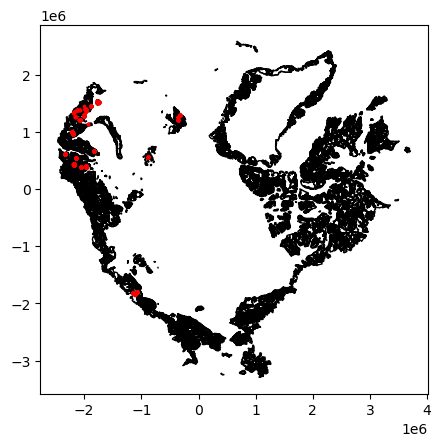

In [14]:
# plot the post-2010 russian tundra points
ax = tundra.plot(edgecolor='black', facecolor='none')
rava_points.plot(ax=ax, color='red', markersize=3)

In [15]:
# print a list of the AVA datasets we will be harmonizing
rava_datasets = sorted(rava_points['DATASET'].unique())
print(rava_datasets)

['Bolshezemelskaya Tundra', 'EAT', 'G1_Yambuto_lake', 'G3_Tanama_river', 'G4_Parisento_lake', 'Indigirka', 'Oxycocco-Sphagnetea', 'Polar_Ural_10', 'Polar_Ural_11', 'Polar_Ural_12', 'Polar_Ural_13', 'Polar_Ural_14', 'Polar_Ural_15', 'Polar_Ural_16', 'Polar_Ural_17', 'Polar_Ural_18', 'Polar_Ural_19', 'Polar_Ural_20', 'Polar_Ural_21', 'Polar_Ural_22', 'Polar_Ural_23', 'Polar_Ural_24', 'Polar_Ural_25', 'Polar_Ural_26', 'Polar_Ural_27', 'Polar_Ural_28', 'Polar_Ural_29', 'Polar_Ural_3', 'Polar_Ural_30', 'Polar_Ural_31', 'Polar_Ural_32', 'Polar_Ural_33', 'Polar_Ural_34', 'Polar_Ural_35', 'Polar_Ural_36', 'Polar_Ural_37', 'Polar_Ural_38', 'Polar_Ural_39', 'Polar_Ural_4', 'Polar_Ural_40', 'Polar_Ural_41', 'Polar_Ural_42', 'Polar_Ural_43', 'Polar_Ural_44', 'Polar_Ural_45', 'Polar_Ural_46', 'Polar_Ural_47', 'Polar_Ural_48', 'Polar_Ural_49', 'Polar_Ural_5', 'Polar_Ural_50', 'Polar_Ural_51', 'Polar_Ural_52', 'Polar_Ural_53', 'Polar_Ural_54', 'Polar_Ural_55', 'Polar_Ural_56', 'Polar_Ural_57', 'Polar

### 1.1.4. Exatract auxialiary-only information (non-cover)

In [16]:
rava_points.columns = [col.lower().replace(' ', '_') for col in rava_points.columns]

In [17]:
# extract columns that DO NOT have "cover" in the name; this is auxiliary info
aux_cols = [col for col in rava_points.columns if 'cover' not in col]
aux = rava_points[aux_cols].copy()

---
## 1.3. Foliar Data

### 1.3.1. Exatract non-foliar cover info from auxiliary

In [18]:
# extract columns with "cover" in the name; these contain the fcover data
cover_cols = [col for col in rava_points.columns if 'cover' in col]
nonfoliar_fcover = rava_points[cover_cols].copy()
nonfoliar_fcover.drop(columns=['coverscale'], inplace=True) # not fcover

In [19]:
# extract non-vegetation fcover columns
etc = ['cover_crust(%)','cover_bare_soil_(%)','cover_bare_rock_(%)','cover_open_water_(%)']
non_veg = nonfoliar_fcover[etc]
litter = nonfoliar_fcover[['cover_litter_layer_(%)']]

# Remove the stuff we pulled out
etc.append('cover_litter_layer_(%)')
nonfoliar_fcover.drop(columns=etc, inplace=True)

### 1.3.2. Extract folar fcover data

In [20]:
# get paths to tables
species_csv_paths = sorted(glob.glob(f'input_data/rava_cover_tables/*fcover_data.csv'))

In [21]:
# load tables in pandas; not all tables have known encoding
fcover_dfs = []
for path in species_csv_paths:
    with open(path, 'rb') as file:
        # dynamically detect file encoding because it is not consistent
        result = chardet.detect(file.read())
    df = pd.read_csv(path, encoding=result['encoding'], encoding_errors='replace', 
                     na_values=[-9, -9.0, '-9', '-9.0'], header=0, skiprows=[1])
    fcover_dfs.append(df)
fcover_dfs[3].head(3)

,PASL TAXON SCIENTIFIC NAME NO AUTHOR(S),PASL TAXON SCIENTIFIC NAME WITH AUTHOR(S),DATASET TAXON,G1-1,G1-4,G1-5,G1-10,G1-11,G1-14,G1-16,...,G1-136,G1-138,G1-140,G1-142,G1-144,G1-146,G1-148,G1-150,G1-152,G1-154
0,Abietinella abietina,Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Achoriphragma nudicaule,Parrya nudicaulis (L.) Regel,Achoriphragma nudicaule,0,2,3,0,2,0,0,...,0,0,0,0,2,0,0,0,0,0
2,Alectoria ochroleuca,Alectoria ochroleuca (Hoffm.) Massal.,Alectoria ochroleuca,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [22]:
# get unique species names from ALL tables (not just post-2010)
species_names = []
for df in fcover_dfs: 
    names = df.iloc[:, 1] # second col with author (I found that no-author names didn't align with authored names)
    for name in names:
        if pd.notnull(name):
            name = name.strip('[]')
            name = name.strip()
            species_names.append(name)
u_species_names = list(set(species_names))

# remove null species names
u_species_names = [x for x in u_species_names if pd.notnull(x)]
print('Non-nan unique species names for ALL fcover data: ', len(u_species_names))
species_names_df = pd.DataFrame(u_species_names, columns=['datasetSpeciesName'])

Non-nan unique species names for ALL fcover data:  1988


---
## 1.4. Join fcover to species checklist table

In [23]:
# load species checklist and prep for joining
checklist_path = '../etc/akveg_species_checklist.csv'
checklist_df = spf.checklist_df(checklist_path)
checklist_df.head(3)

,nameCode,checklistSpeciesName,nameStatus,nameAccepted,nameFamily,acceptedNameSource,nameLevel,speciesForm,speciesHabit
0,abroth,Abrothallus De Not.,accepted,Abrothallus De Not.,Abrothallaceae,CNALH,genus,lichen,lichen
1,abrpar,Abrothallus parmeliarum (Sommerf.) Arnold,accepted,Abrothallus parmeliarum (Sommerf.) Arnold,Abrothallaceae,CNALH,species,lichen,lichen
2,abrpey,Abrothallus peyritschii (Stein) Kotte,accepted,Abrothallus peyritschii (Stein) Kotte,Abrothallaceae,Dillman et al. 2012,species,lichen,lichen


In [24]:
species_names_df.head(3)

,datasetSpeciesName
0,Juncus biglumis
1,Calliergon cordifolium (Hedw.) Kindb.
2,Angelica archangelica [s. archangelica] L.


In [25]:
# get first 2 words (genus-species) from checklist accepted name and data species name
checklist_df['joinKey'] = checklist_df['checklistSpeciesName'].apply(spf.get_substrings)
species_names_df['joinKey'] = species_names_df['datasetSpeciesName'].apply(spf.get_substrings)
habits = spf.join_to_checklist(unique_species=species_names_df, 
                               checklist=checklist_df, 
                               u_name='datasetSpeciesName', 
                               c_unofficial_name='checklistSpeciesName', 
                               c_official_name='nameAccepted', 
                               mapping_name='joinKey',
                               habit='speciesHabit')
habits.head(3)

708 species are missing habits.
432 species still missing habits.
69 species still missing habits.
50 species still missing habits.


,datasetSpeciesName,joinKey,speciesHabit
index,,,
0,Juncus biglumis,Juncus biglumis,graminoid
1,Calliergon cordifolium (Hedw.) Kindb.,Calliergon cordifolium,moss
2,Angelica archangelica [s. archangelica] L.,Angelica archangelica,forb


In [26]:
species_names_df.head(3)

,datasetSpeciesName,joinKey
0,Juncus biglumis,Juncus biglumis
1,Calliergon cordifolium (Hedw.) Kindb.,Calliergon cordifolium
2,Angelica archangelica [s. archangelica] L.,Angelica archangelica


In [27]:
habits = species_names_df.merge(habits, how='left', left_on='datasetSpeciesName', right_on='datasetSpeciesName', suffixes=(None, '_1'))
habits = habits[['joinKey', 'datasetSpeciesName', 'speciesHabit']]

---
## 1.5. Join fcover to leaf retention table

In [28]:
# load leaf retention table and clean
path = '../etc/macander_leaf_retention.csv'
leaf_ret = spf.leaf_retention_df(path)
leaf_ret.head(3)

,leafRetention,retentionSpeciesName
0,deciduous,Salix
1,deciduous,Betula nana
2,deciduous,Vaccinium uliginosum


In [29]:
# add leaf retention column
habits_wleaf = spf.add_leaf_retention(habits, leaf_ret, 'leafRetention')
habits_wleaf = habits_wleaf[['datasetSpeciesName', 'joinKey', 'speciesHabit', 'leafRetention']]
habits_wleaf.head(3)

,datasetSpeciesName,joinKey,speciesHabit,leafRetention
0,Juncus biglumis,Juncus biglumis,graminoid,
1,Calliergon cordifolium (Hedw.) Kindb.,Calliergon cordifolium,moss,
2,Angelica archangelica [s. archangelica] L.,Angelica archangelica,forb,


In [30]:
# apply function
habits_wleaf['speciesHabit'] = habits_wleaf['speciesHabit'].apply(spf.clean_shrub_habits)
list(habits_wleaf['speciesHabit'].unique())

['graminoid',
 'moss',
 'forb',
 nan,
 'lichen',
 'shrub',
 'spore-bearing',
 'liverwort',
 'coniferous tree']

---
## 1.6. Export species-PFT tables

In [31]:
# generate 3 files and dataframe of habit types
shrubs, nonshrubs, null = spf.export_habit_files(habits_wleaf,
                                                 'temp_data', 
                                                 source, 
                                                 'speciesHabit')

In [32]:
# check to make sure the files make sense
len(habits_wleaf) == (len(null) + len(nonshrubs) + len(shrubs))

True

---
## 1.7. Clean exported species-PFT tables <a name="cleanhabits"></a>
Here, we manually assessed each file. The nonshrubs were usually correct and did not have to be adjusted. Some shrubs were missing leaf retention information, so we consulted with arctic ecologists to determine it. For unknown (null) habits, we consulted arctic ecology expert, Amy Breen, to determine the issue and correct habit. After the tables were complete, all species names had a single associated habit.
- null habits
    - assign missing habits and consult ecologist when needed
- non-shrubs
    - assign leaf habit to all trees (ctrl-f to find all trees in excel)
        - coniferous tree = evergreen
        - deciduous tree  = deciduous
    - remove leaf habit if misapplied
- shrubs
    - check current leaf habits and correct if necessary
    - fill empty leaf habits
    - choose leaf habit if both evergreen & deciduous listed
    - add Stature column (dwarf shrub or not)

---
---
# 2. Standardization <a name="standardization"></a>

---
## 2.1. Standardize PFT names <a name="pftnames"></a>
deciduous shrub, evergreen shrub, graminoid, forb, litter, non-vascular (lichen, brophyte)

In [35]:
# paths to visually assessed and cleaned habit files
all_habit_types = [f'temp_data/{source}_nonshrubs_01.csv',
                   f'temp_data/{source}_shrubs_01.csv',
                   f'temp_data/{source}_nullhabit_01.csv']

# create list of habit dataframes
habit_dfs = []
for path in all_habit_types:
    habit_df = pd.read_csv(path, index_col=0)
    habit_dfs.append(habit_df)
all_habits = pd.concat(habit_dfs)

In [36]:
# show unique habit names we're working with
all_habits['speciesHabit'].unique().tolist()

['graminoid',
 'moss',
 'forb',
 'lichen',
 'spore-bearing',
 'liverwort',
 'shrub',
 'tree',
 'bryophyte',
 'other']

In [37]:
# ava-specific habit name standardization function
def standardize_habit(habitrow, leafrow):
    
    habitrow = habitrow.to_numpy()
    leafrow = leafrow.to_numpy()
    new_row = []
    
    for habit, leaf in zip(habitrow, leafrow):
        
        habit = habit.lower()
        # non-shrubs
        if 'moss' in habit or 'liverwort' in habit:
            new_habit = 'bryophyte'
        elif 'spore-bearing' in habit:
            new_habit = 'forb'
            
        # shrubs and trees
        elif 'shrub' in habit:
            new_habit = f'{leaf} shrub'
        elif 'tree' in habit:
            new_habit = f'{leaf} tree'
            
        else:
            new_habit = f'{habit}'
        new_row.append(new_habit)
    
    return new_row

In [38]:
# standardized PFT
standard_habit_col = standardize_habit(all_habits['speciesHabit'], 
                                       all_habits['leafRetention'])
all_habits['standardHabit'] = standard_habit_col
all_habits.rename(columns={'speciesHabit':'nonstandardHabit'}, inplace=True)
print(len(all_habits))
all_habits.head(3)

1988


,datasetSpeciesName,joinKey,nonstandardHabit,leafRetention,standardHabit
0,Juncus biglumis,Juncus biglumis,graminoid,NaN,graminoid
1,Calliergon cordifolium (Hedw.) Kindb.,Calliergon cordifolium,moss,NaN,bryophyte
2,Angelica archangelica [s. archangelica] L.,Angelica archangelica,forb,NaN,forb


---
## 2.2. Sum species fcover to PFT-level

In [47]:
# print cover types in this data
rava_points['coverscale'].unique()

array([0, 'BB', 2, nan], dtype=object)

# Cover scale codes:
0 = percent

BB = braun blanquet

2 = braun blanquet

In [ ]:
# ava-specific function to clean fcover values
from IPython.display import display, clear_output
import time
import pandas as pd
import numpy as np
import chardet
import os

def get_fcover_percent(paths, all_habits, habit_col, species_col):
    
    pft_fcover_tables = []
    species_fcover_tables = []  # New dataset with plotName, speciesNameNoAuth, percentCover columns
    
    cover_types = []
    
    # get fcover type from filename
    basenames = [os.path.basename(path) for path in paths]
    for name in basenames:
        cover_type = name.split('_')[-2]
        cover_types.append(cover_type)
    all_habits = all_habits[[species_col, habit_col]]
    
    # loop through each fcover table
    for path, cover_type in zip(paths, cover_types):

        # read table
        with open(path, 'rb') as file:
            result = chardet.detect(file.read())
            df = pd.read_csv(path, encoding=result['encoding'], 
                             header=1, 
                             na_values=[-9, -9.0, '-9', '-9.0'])
        clear_output(wait=True)
        display(habit_col, path)
        time.sleep(1)

        # rename columns
        cols = df.columns.to_numpy()
        cols[0] = 'speciesNameNoAuth'
        cols[1] = 'speciesNameAccepted'
        cols[2] = 'speciesName'
        df.columns = cols

        # get list of plot IDs
        plot_id_cols = df.columns.to_list()[3:]

        # get associated habit for each species
        df = df.merge(all_habits, left_on='speciesNameAccepted', right_on=species_col)

        # br-bq to percentage conversion dict
        # Wood 2013. EFFECTS OF PRESCRIBED BURNING ON GRASSLAND AVIFAUNA AT RIVERLANDS MIGRATORY BIRD SANCTUARY
        bb_dict = {'r': 0.05, '+': 0.55, '1': 3.0, '2': 15.0, '3': 37.5, '4': 62.5, '5': 87.5, '-9': np.nan}
        # Westoff converstion dict
        wv_dict = {'1': 0.05, '2': 1.0, '3': 2.5, '4': 4.5, '5': 9.0, '6': 18.5, '7': 37.0, '8': 62.0, '9': 87.5}
        # Hult-Serander conversion dict
        hs_dict = {'+': 0.5, '1': 4.0, '2': 9.0, '3': 18.0, '4': 38.0, '5': 63.0, '6': 87.0}

        # convert wv codes
        if cover_type == 'wv':

            # replace westoff-van den maarel code with percentage
            cols = df.columns.to_list()
            df = df.astype(str)
            for col in cols:
                df.replace({col: wv_dict}, inplace=True)

        # covert br-bl codes        
        elif cover_type == 'brbl':

            # replace br-bl code with percentage
            cols = df.columns.to_list()
            df = df.astype(str)
            for col in cols:
                df.replace({col: bb_dict}, inplace=True)

        elif cover_type == 'hs':

            # replace hs code with percentage
            cols = df.columns.to_list()
            df = df.astype(str)
            for col in cols:
                df.replace({col: hs_dict}, inplace=True)

        # if already percent
        else:

            df = df.astype(str)

        # clean % data
        fcover = df.drop(columns=['speciesNameNoAuth', 'speciesNameAccepted', 'speciesName', species_col])
        fcover = fcover.loc[:, fcover.columns != habit_col].replace(' ', '0', regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].replace('', '0', regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].replace('\*', '0', regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].astype(float)

        # add back the standard habit column
        fcover = fcover.copy()
        fcover[habit_col] = df[habit_col] # replace codes with new fcover %

        # loop through each plot and sum fcover per pft
        pft_fcover = fcover.groupby(by=[habit_col]).sum().T
        pft_fcover.index = plot_id_cols
        pft_fcover['fcoverScale'] = cover_type
        pft_fcover_tables.append(pft_fcover)
        
        # Reshape the dataset to match the desired structure
        df_melted = df.melt(id_vars=['speciesNameNoAuth'], value_vars=plot_id_cols, var_name='plotName', value_name='percentCover')
        
        # Replace problematic values and convert percentCover to float
        df_melted['percentCover'] = pd.to_numeric(df_melted['percentCover'], errors='coerce').fillna(0)
        
        species_fcover_tables.append(df_melted[['plotName', 'speciesNameNoAuth', 'percentCover']])
    
    return pft_fcover_tables, species_fcover_tables